In this notebook, CNN based architecture has been used for classification purpose on a subset of 'rvlcdip' kaggle dataset. The dataset has document images. The subset has 16 classes with 48000 samples in total. The program has been run on Google Colab and due to resource limit, 40% of the dataset was used (including training, validating and testing)

Input csv file has list of image names (in .tif format) and labels (0-15).

In [1]:
#Import dataset from Kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gowtamsingulur/rvlcdip")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rvlcdip


In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
dir_path = path
os.listdir(dir_path)

['labels_final.csv', 'data_final']

In [4]:
print(dir_path)

/kaggle/input/rvlcdip


In [5]:
#Load the csv file
filename = 'labels_final.csv'
csv_path = os.path.join(dir_path, filename)

df = pd.read_csv(csv_path)
df.head()    #CSV file has image file name including relative path and label

,path,label
0,imagesv/v/o/h/voh71d00/509132755+-2755.tif,3
1,imagesl/l/x/t/lxt19d00/502213303.tif,3
2,imagesx/x/e/d/xed05a00/2075325674.tif,2
3,imageso/o/j/b/ojb60d00/517511301+-1301.tif,3
4,imagesq/q/z/k/qzk17e00/2031320195.tif,7


In [65]:
df.shape

(48000, 2)

In [6]:
df['label'].unique() #Unique labels in dataset

array([ 3,  2,  7,  4,  1, 13,  5,  6,  0, 15, 11,  8, 14, 10, 12,  9])

In [7]:
classes = df['label'].unique()
classes = np.sort(classes)
print(classes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [8]:
#Number of samples of each class
class_counts = df['label'].value_counts().sort_index()

print(class_counts)

label
0     3016
1     2994
2     2993
3     3005
4     2994
5     2999
6     2985
7     3000
8     3003
9     3002
10    3002
11    2992
12    3006
13    3007
14    3006
15    2996
Name: count, dtype: int64


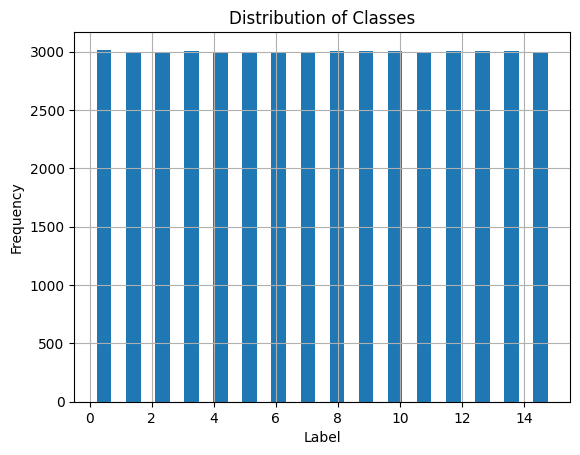

In [9]:
#Plotting the histogram of number of samples of each class
#Each class is equally represented
import matplotlib.pyplot as plt

min_label = min(df['label'].unique())
max_label = max(df['label'].unique())

# pandas.DataFrame.plot / pandas.DataFrame.plot.hist
df['label'].hist(bins = (max_label - min_label + 1), rwidth=0.5)

#plt.xticks(range(min_label,max_label))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of Classes')
plt.show()

Plotting few samples of each document class

In [10]:
from PIL import ImageFile
from PIL import Image, ImageDraw

import random

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
def plot_random_images(df, image_dir, class_col, num_images=4):
    """
    Plots a specified number of random images for each class in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with a column specifying image file paths and a class column.
        image_dir (str): Directory where the images are stored.
        class_col (str): Name of the column containing class labels.
        num_images (int): Number of random images to plot per class.
    """

    classes = df[class_col].unique()
    classes.sort()
    print(classes)
    for class_name in classes:
        #Randomly selecting num_samples from a class
        class_df = df[df[class_col] == class_name]
        num_samples = min(num_images, len(class_df))
        random_indices = random.sample(range(len(class_df)), num_samples)

        #Plotting the images of a class
        plt.figure(figsize=(10, 2 * num_samples))
        plt.suptitle(f"Class: {class_name}", fontsize=16)

        for i, index in enumerate(random_indices):
            a = 'data_final'
            image_path = os.path.join(image_dir, a, class_df.iloc[index]['path']) #assuming filename is the column with image name
            try:
                image = Image.open(image_path)
                width, height = image.size

                label = class_df.iloc[index]['label']

                #print(image_path)
                plt.subplot(num_samples, num_images, i + 1)
                # Create a drawing object
                draw = ImageDraw.Draw(image)

                plt.imshow(image)
                plt.title(f"Image {i + 1}")
                plt.axis('off')
            except FileNotFoundError:
                 print(f"Image not found: {image_path}")
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


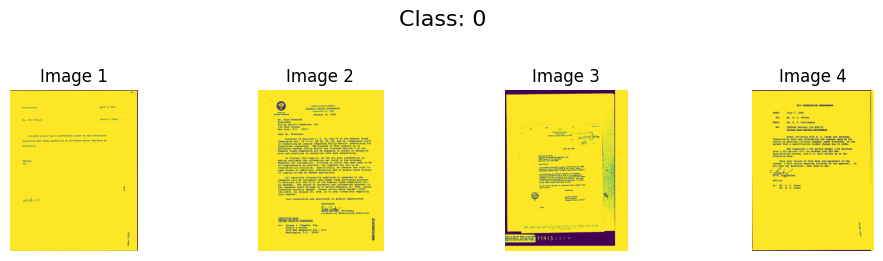

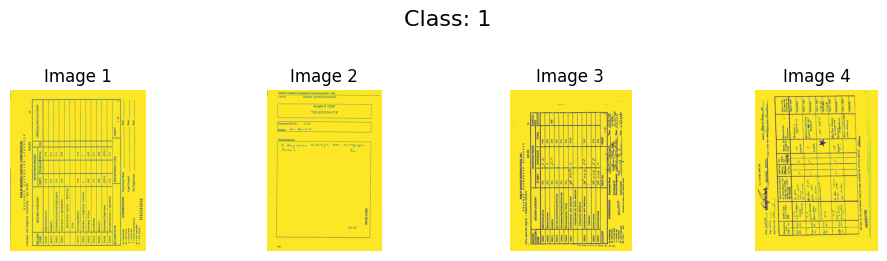

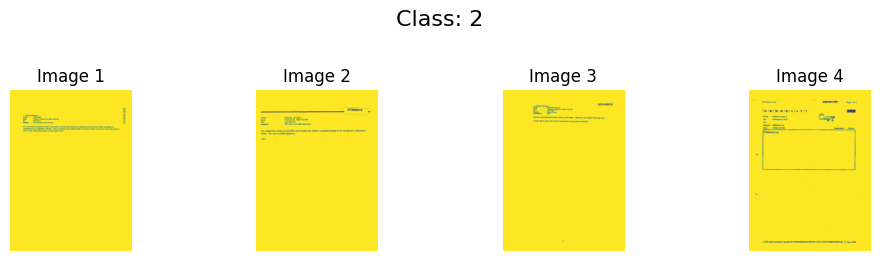

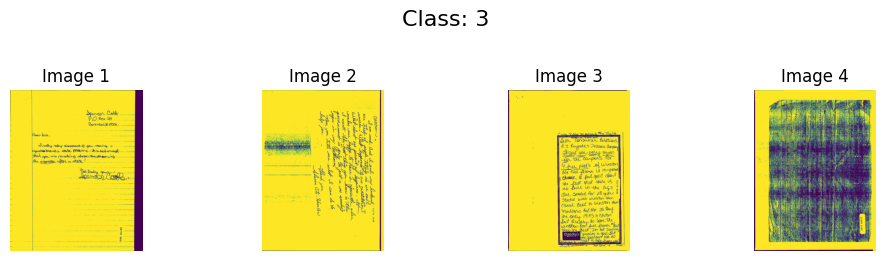

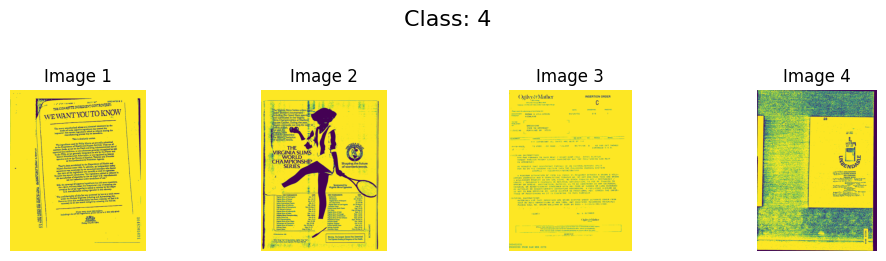

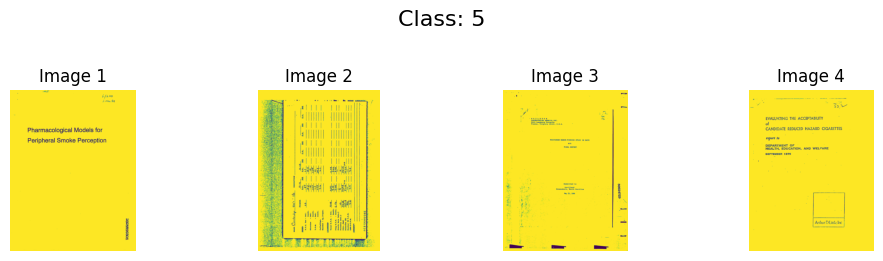

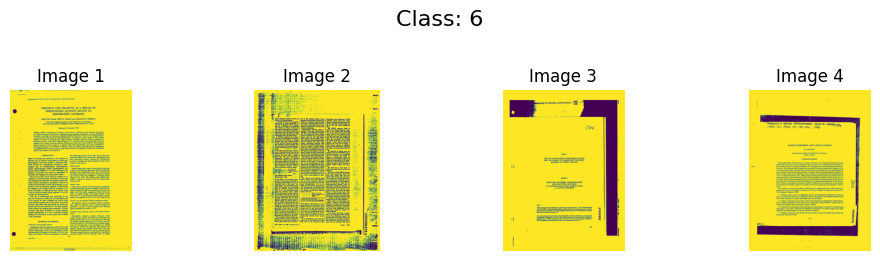

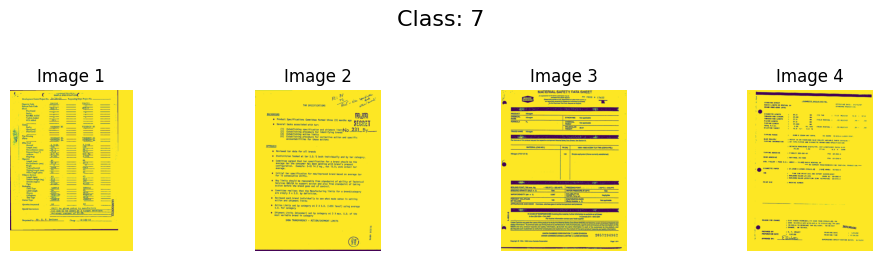

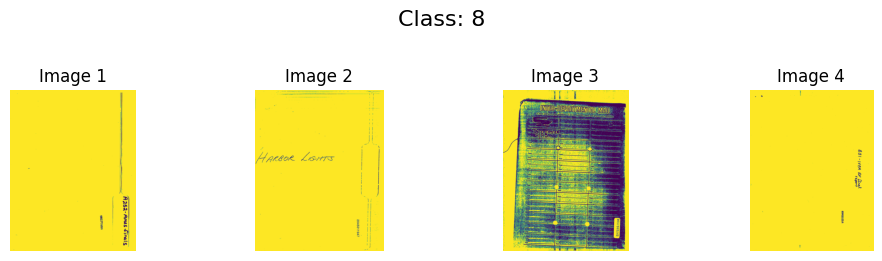

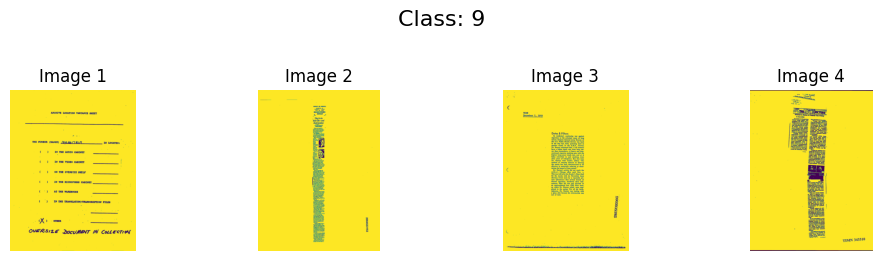

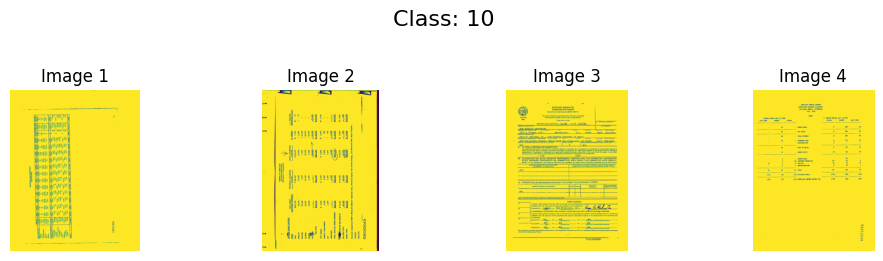

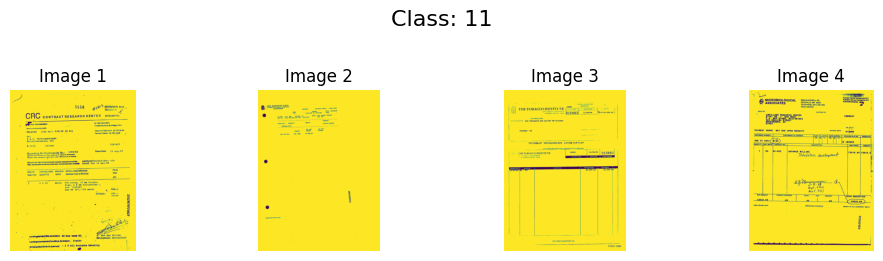

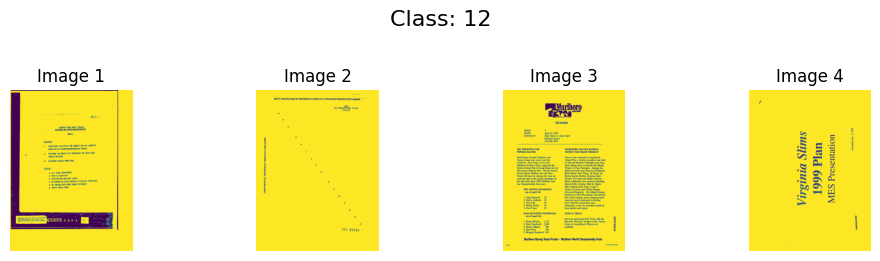

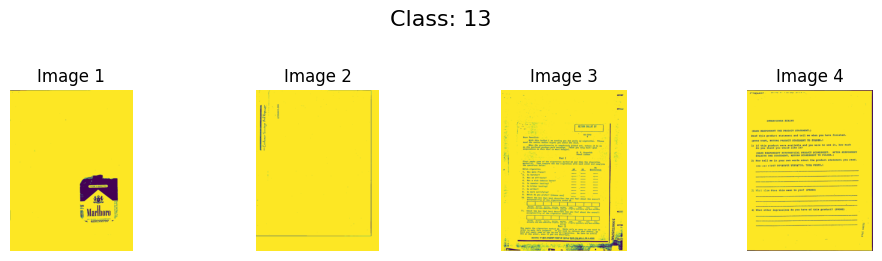

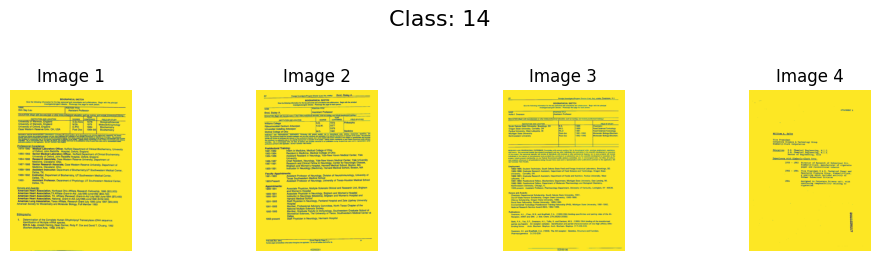

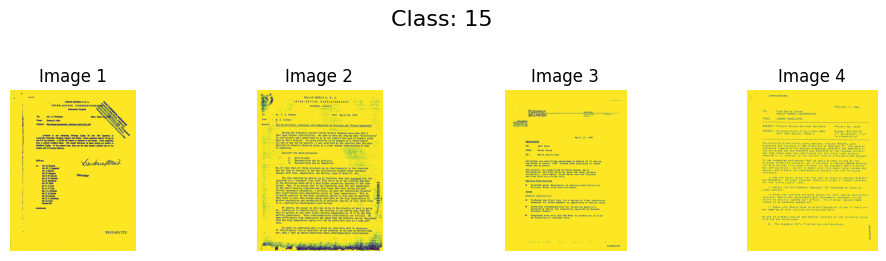

In [12]:
# Example usage (assuming you have a DataFrame named 'image_df'):
image_df = df
plot_random_images(df, dir_path, 'label', num_images=4)

CNN model for classification purpose


*   3 convolution layers (32, 64, 128 filters)
*   3 Fully Connected Layers with last layers for classification
*   'Relu' as activation function
*   Use DatasetLoader for loading data
*   Use CustomDataSet for retreiving an image



In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

In [14]:
# Define a sequence of transforms - Horizontalflip, Rotation, Translation, Shear
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 256x256 pixels
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flip horizontally
    transforms.RandomRotation(degrees=10), # Randomly rotate up to 30 degrees
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1), shear=0.1),
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor (values between 0 and 1)
])

# Don't augment test data, only reshape
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [15]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, image_paths, labels, transform=None):
        self.root_dir = root_dir
        self.image_paths = image_paths   #dataframe
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = str(self.image_paths.iloc[idx]['path'])
        img_path = os.path.join(self.root_dir, 'data_final', image_path)   #Image is at Root Dir + data_final + reference path given in dataframe

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)    #Apply transform on image

        label = self.labels.iloc[idx]        #Label of the image
        return image, label

As number of sample is high, taking only 40% of dataset for train, valid and test

60-20-20 split for training, vaidation and testing

In [45]:
from sklearn.model_selection import train_test_split

y = df['label']  # Target variable
X = df.drop('label', axis=1)  # Features

#Taking 40% of dataset
X_left, X_train, y_left, y_train = train_test_split(X, y, test_size=0.4, random_state=42)


In [46]:
len(X_train)

19200

In [47]:
#Splitting 20% as test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #As number of sample is high, taking only 40% of dataset for train, valid and test


In [49]:
len(X_test)

3840

In [50]:
#Splitting 20% of remaining as validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #As number of sample is high, taking only 40% of dataset for train, valid and test


In [56]:
len(X_val)

3072

In [57]:
# Create your custom dataset
train_dataset = CustomDataset(root_dir=dir_path, image_paths=X_train, labels=y_train, transform=train_transform)
val_dataset = CustomDataset(root_dir=dir_path, image_paths=X_val, labels=y_val, transform=train_transform)
test_dataset = CustomDataset(root_dir=dir_path, image_paths=X_test, labels=y_test, transform=test_transform)


In [58]:
print(train_dataset.__len__())
print(val_dataset.__len__())
print(test_dataset.__len__())

12288
3072
3840


In [59]:
#Setting datasetloader for training, validation and testing
batch_size = 200
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [60]:
# Example of iterating through dataloaders
for images, labels in train_dataloader:
    print("Training batch: ", images.shape, labels.shape)
    break

for images, labels in val_dataloader:
    print("Validation batch: ", images.shape, labels.shape)
    break

for images, labels in test_dataloader:
    print("Testing batch: ", images.shape, labels.shape)
    break


Training batch:  torch.Size([200, 3, 224, 224]) torch.Size([200])
Validation batch:  torch.Size([200, 3, 224, 224]) torch.Size([200])
Testing batch:  torch.Size([200, 3, 224, 224]) torch.Size([200])


CNN Model

In [24]:
class CNN(nn.Module):
    def __init__(self, num_classes=16):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='valid')
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='valid')
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='valid')
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(26*26*128, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 26 * 26 * 128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
model = CNN()

In [26]:
#Moding the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (fc1): Linear(in_features=86528, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
)

In [27]:
#Setting Optimizer and Loss Criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
#Defining function for training and validating the model in each epoch, measuing the accuracy
from sklearn.metrics import accuracy_score

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


In [29]:
#Defining the evaluation mode for test images
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, test_loader, classes):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Compute confusion matrix and classification report
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [62]:
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10)


Epoch 1/10, Train Loss: 2.0668, Train Accuracy: 34.16%, Val Loss: 1.9445, Val Accuracy: 38.77%
Epoch 2/10, Train Loss: 1.9457, Train Accuracy: 38.35%, Val Loss: 1.8506, Val Accuracy: 42.35%
Epoch 3/10, Train Loss: 1.8315, Train Accuracy: 41.84%, Val Loss: 1.7702, Val Accuracy: 44.30%
Epoch 4/10, Train Loss: 1.7990, Train Accuracy: 43.21%, Val Loss: 1.7762, Val Accuracy: 44.04%
Epoch 5/10, Train Loss: 1.7085, Train Accuracy: 46.58%, Val Loss: 1.6857, Val Accuracy: 47.30%
Epoch 6/10, Train Loss: 1.6581, Train Accuracy: 48.45%, Val Loss: 1.6862, Val Accuracy: 47.85%
Epoch 7/10, Train Loss: 1.6075, Train Accuracy: 50.02%, Val Loss: 1.5742, Val Accuracy: 52.05%
Epoch 8/10, Train Loss: 1.5526, Train Accuracy: 51.78%, Val Loss: 1.6024, Val Accuracy: 50.07%
Epoch 9/10, Train Loss: 1.5208, Train Accuracy: 53.14%, Val Loss: 1.5749, Val Accuracy: 51.30%
Epoch 10/10, Train Loss: 1.4739, Train Accuracy: 54.25%, Val Loss: 1.5164, Val Accuracy: 52.86%


Test Accuracy: 0.5729, Precision: 0.5755, Recall: 0.5729, F1-Score: 0.5635
Confusion Matrix:
[[143  20   5   3   2   4   2   5   2   4   0   8   5   7  14  11]
 [  6  94   2   9   4   1   1  22   3   6  15  12   6   9   5   7]
 [  6   3 217   1   1   0   5   2   1   3   2   1   1   3   6   2]
 [  1  13   0 174   9   2   0  10   8   2  16   7   5   2   0   0]
 [  1   7   1   1 168   2   1   2  13  13   2   4   7   3   0   2]
 [ 17  25  10   3   8  47  10  11   7   6  25  12  36  12  17   8]
 [  3   2   0   0   2   7 180   0   4  19   0   0   4   8   0   0]
 [  4  34   1   3   0   2   2 142   1   3   6   6   2  16   9   6]
 [  1   1   2   3  13   0   0   0 236   1   3   0   8   0   0   0]
 [  1   5   3   2  12   0  31   2   1 172   1   2   6   4   3   0]
 [  3  37  12  12   3   2   2  18   5   3  87  23   4  10   6   5]
 [  8  34   3  12  10   2   1  18   4   3  23  85   2   7   1   4]
 [ 11  14   2   7  11   8   5   2  11   3  10   1 124  10   5  11]
 [  9  55   5   6   6   7   1  25  1

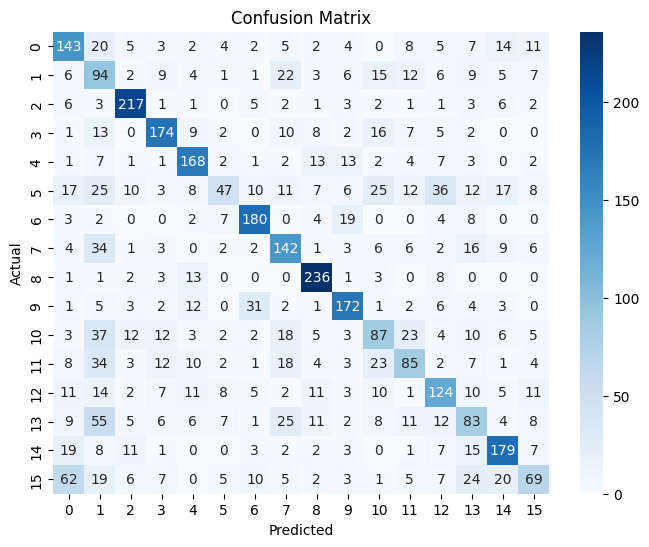

In [64]:
evaluate_model(model, test_dataloader, classes)